# imports

In [1]:
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import os
import random
import shutil
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
import json
import numpy as np
from PIL import Image

Using TensorFlow backend.


# downolad vgg weights

In [2]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

# network definition

In [3]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [4]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [5]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [6]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [7]:
K.set_image_dim_ordering('th')

In [8]:
model = VGG_16()

In [9]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [10]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
lr = 0.001
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Load the weights if we dont want to re train

In [9]:
model.load_weights("gender_recognition_weights.h5")

# Shuffle training and validation images

In [11]:
def move_files(src_path, dest_path):
    files = os.listdir(src_path)
    for f in files:
        complete_path = src_path + f
        shutil.move(complete_path, dest_path)
def move_shuffle(src_path, dest_path):
    files = os.listdir(src_path)
    files = random.sample(files, 200)
    for f in files:
        complete_path = src_path + f
        shutil.move(complete_path, dest_path)
valid_path = "images/validation/"
valid_path_male = valid_path + 'male/'
valid_path_female = valid_path + 'female/'
train_path = "images/train/"
train_path_male = train_path + 'male/'
train_path_female = train_path + 'female/'
move_files(valid_path_female, train_path_female)
move_shuffle(train_path_female, valid_path_female)
move_files(valid_path_male, train_path_male)
move_shuffle(train_path_male, valid_path_male)


# Get the training and validation images

In [12]:
batch_size = 10

In [13]:
gen=image.ImageDataGenerator()
batch_train = gen.flow_from_directory('images/train', target_size=(224,224),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 1305 images belonging to 2 classes.


In [14]:
batch_valid = gen.flow_from_directory('images/validation', target_size=(224,224),
                class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 400 images belonging to 2 classes.


# Train the network

In [15]:
model.fit_generator(batch_train, samples_per_epoch=batch_train.nb_sample, nb_epoch=1,
                validation_data=batch_valid, nb_val_samples=batch_valid.nb_sample)


Epoch 1/1
1305/1305 [==============================] - 115s - loss: 0.3407 - acc: 0.8690 - val_loss: 0.1823 - val_acc: 0.9400


# Save the weights so we dont need to re traint the network on reuse

In [16]:
model.save_weights("gender_recognition_weights.h5")

# Get images to predict on and make predictions

In [17]:
test_batches = gen.flow_from_directory('images/test',target_size=(224,224), 
                                       shuffle=False, batch_size=10, class_mode=None)


Found 328 images belonging to 1 classes.


In [18]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [19]:
predictions = preds[:,0]
labels= np.round(1-preds[:,0])

# Visualize 

In [20]:
from matplotlib import pyplot as plt
from keras.preprocessing import image
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



In [21]:
%matplotlib inline

In [22]:
filenames = test_batches.filenames

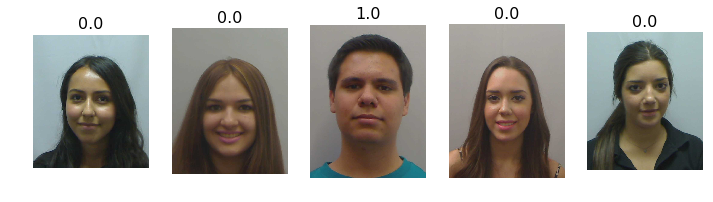

In [43]:
import random
n_view = 5
n = random.randint(0, len(filenames) - n_view)
imgs = [image.load_img('images/test/' + filenames[i+n]) for i in xrange(n_view)]
idx = [i+n for i in xrange(n_view)]
plots(imgs, titles=labels[idx])


# Move files according to results

In [ ]:
for i in xrange(len(filenames)):
    fname = 'images/test/'+filenames[i]
    if(labels[i] == 0):
        %mv $fname female/
    else:
        %mv $fname male/

# Lets Investigate a bit

In [44]:
gen=image.ImageDataGenerator()
_path = "images/validation"
#_path = "images/train"
test_batches = gen.flow_from_directory(_path,target_size=(224,224), 
                                       shuffle=False, batch_size=10, class_mode=None)
expected_labels = test_batches.classes

Found 400 images belonging to 2 classes.


In [45]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [46]:
our_predictions = preds[:,0]
our_labels= np.round(1-preds[:,0])

filenames = test_batches.filenames

In [47]:
n_view = 6
def plots_idx(idx, titles=None):
    plots([image.load_img(_path +'/' + filenames[i]) for i in idx], titles=titles)

# Images we're _most_ confident are girls that are actually girls

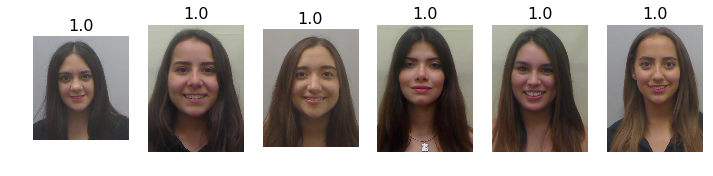

In [48]:

correct_girls = np.where((our_labels==0) & (our_labels==expected_labels))[0]
most_correct_girls = np.argsort(our_predictions[correct_girls])[::-1][:n_view]
plots_idx(correct_girls[most_correct_girls], our_predictions[correct_girls][most_correct_girls])

# Images we're _most_ confident are boys that are actually boys

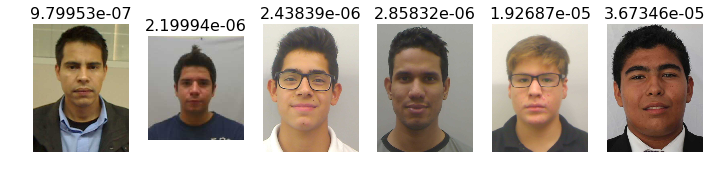

In [49]:
correct_boys = np.where((our_labels==1) & (our_labels==expected_labels))[0]
most_correct_boys = np.argsort(our_predictions[correct_boys])[:n_view]
plots_idx(correct_boys[most_correct_boys], our_predictions[correct_boys][most_correct_boys])

# Images we're _most_ confident are girls that are actually boys

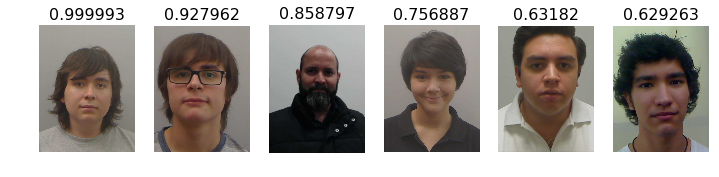

In [50]:
incorrect_girls = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
most_incorrect_girls = np.argsort(our_predictions[incorrect_girls])[::-1][:n_view]
plots_idx(incorrect_girls[most_incorrect_girls], our_predictions[incorrect_girls][most_incorrect_girls])
#[filenames[i] for i in incorrect_girls[most_incorrect_girls]]

# Images we're _most_ confident are boys that are actually girls

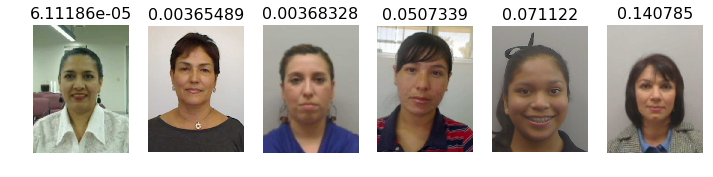

In [51]:
incorrect_boys = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
most_incorrect_boys = np.argsort(our_predictions[incorrect_boys])[:n_view]
plots_idx(incorrect_boys[most_incorrect_boys], our_predictions[incorrect_boys][most_incorrect_boys])

# Images we're most uncertain wether they're boys or girls

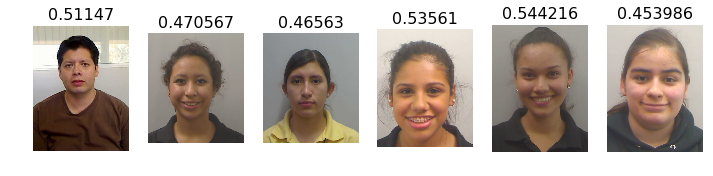

In [52]:
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])